# Objective : 

* **Find turning speeds.**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import mplleaflet

In [19]:
df = pd.read_csv("datasets/company_raw.csv")
df.columns = ["index", "heading", "id", "img_front", "lat", "lon", "speed", "timestamp"]
df.head()

,index,heading,id,img_front,lat,lon,speed,timestamp
0,7191,NE,DB002,NaN,18.528308,73.873303,0.0,1537409201000
1,7192,NE,DB002,img_front_DB002_2018_09_20_07_36_41_369000.jpg,18.528308,73.873303,0.0,1537409201369
2,7193,NE,DB002,img_front_DB002_2018_09_20_07_36_41_563000.jpg,18.528308,73.873303,0.0,1537409201563
3,7194,NE,DB002,img_front_DB002_2018_09_20_07_36_41_830000.jpg,18.528308,73.873303,0.0,1537409201830
4,7195,NE,DB002,NaN,18.528308,73.873303,0.0,1537409202000


In [20]:
# Removing bad data from last day
df2 = df[30000:]
df = df2

In [62]:
# Function to find distance between 2 coordinates
def find_distance(lat1, long1, lat2, long2):
    
    DOF_lat = lat1 - lat2
    DOF_long = long1 - long2
    
    dist_lat = DOF_lat * 111139
    dist_long = DOF_long * 111139
    
    dist = np.sqrt((dist_lat*dist_lat) + (dist_long*dist_long))
    
    return dist

# Function to calculate total distance
def total_dist(df_trip):

    points_no = len(df_trip)
    total_dist = 0

    for i in range(points_no - 1):
        current_lat = df_trip["lat"].iloc[i]
        current_long = df_trip["lon"].iloc[i]
        next_lat = df_trip["lat"].iloc[i+1]
        next_long = df_trip["lon"].iloc[i+1]
    
        delta = find_distance(current_lat,current_long,next_lat,next_long)
    
        total_dist = total_dist + delta
    
    return (total_dist/1000)

# Function to calculate total time
def total_time(df_trip):
    points_no = len(df_trip)
    total_time = 0
    cnt = 0
    
    for i in range(points_no-1):
        
        current_ts = df["timestamp"].iloc[i]
        next_ts = df["timestamp"].iloc[i+1]
        
        dt1 = datetime.fromtimestamp(current_ts/1000) #Removing milliseconds
        dt2 = datetime.fromtimestamp(next_ts/1000)
        delta = dt2 - dt1
        delta_seconds = delta.total_seconds()
        
        if(delta_seconds >= 0):
            total_time = total_time + delta_seconds
            
        else:
            cnt += 1
        
        if(cnt != 0):
            print("Found", cnt, " negative time values")
        
    return (total_time/3600)

# Function to plot trip with turns
def plot_turns(df_trip, df_turns, height, width):
    plt.figure(figsize=(height,width))
    plt.title("Detection of turns")
    plt.plot(df_trip["lon"],df_trip["lat"],"green")
    plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
    plt.xlabel("Longitudes")
    plt.xlabel("Latitudes")
    plt.show() 
    
# Function to plot trip with turns
def plot_turns_map(df_trip, df_turns, height, width):
    plt.figure(figsize=(height,width))
    plt.title("Detection of turns")
    plt.plot(df_trip["lon"],df_trip["lat"],"green")
    plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
    mplleaflet.show()
    
    

In [22]:
print("Total time duration of the trip in hours : ",total_time(df))
print("Total distance covered in kms :", total_dist(df))

Total time duration of the trip in hours :  7.999713611111075
Total distance covered in kms : 185.19042599920394


In [31]:
# Functions to find turns from previous day's work
# Adding speed data to the dataframe

# Find position based turns (without rotaing axes)
def detect_turn(df_trip):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon", "speed_in", "speed_out"])
    
    df_start = df_trip[0:1]
    lat1 = df_trip["lat"].iloc[0]
    lon1 = df_trip["lon"].iloc[0]
    change = False
    
    for i in range(len(df_trip)):
        
        lat2 = df_trip["lat"].iloc[i]
        lon2 = df_trip["lon"].iloc[i]
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        if(delta_lat != 0) or (delta_lon != 0):
            # Change in lat or long detected
            if change == False:
                # Possible start of a turn
                change = True
                m1 = delta_lat * delta_lon
                df_start = df_trip[i:i+1]
                
                lat1 = lat2
                lon1 = lon2
                
            else:
                # Possible end of turn
                df_end = df_trip[i:i+1]
                m2 = delta_lat * delta_lon
                
                if m1*m2 <= 0:
                    # Turn detected
                    start_index = df_start["index"].iloc[0]
                    end_index = df_end["index"].iloc[0]
                    #start_time = df_start["timestamp"].iloc[0]
                    #print(df_start["timestamp"].iloc[0])
                    start_lat = df_start["lat"].iloc[0]
                    start_lon = df_start["lon"].iloc[0]
                    end_lat = df_end["lat"].iloc[0]
                    end_lon = df_end["lon"].iloc[0]
                    speed_in = df_start["speed"].iloc[0]
                    speed_out = df_end["speed"].iloc[0]
                    
                    df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon,
                                                "speed_in":speed_in, "speed_out":speed_out},
                                                ignore_index=True)
                    change = False
                
                else:
                    # Turn not detected, possible start of new turn
                    df_start = df_end
                    m1 = m2
                    lat1 = lat2
                    lon1 = lon2
            
        else:
            lat1 = lat2
            lon1 = lon2
        
    return df_turns


# Find position based turns (with rotaing axes)
def detect_turn_rotated(df_trip):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon","speed_in","speed_out"])
    
    df_start = df_trip[0:1]
    lat1 = df_trip["lat"].iloc[0]
    lon1 = df_trip["lon"].iloc[0]
    change = False
    
    for i in range(len(df_trip)):
        
        lat2 = df_trip["lat"].iloc[i]
        lon2 = df_trip["lon"].iloc[i]
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        if(delta_lat != 0) or (delta_lon != 0):
            # Change in lat or long detected
            if change == False:
                # Possible start of a turn
                change = True
                delta_lon2 = (0.707*delta_lon) - (0.707*delta_lat)
                delta_lat2 = (0.707*delta_lon) + (0.707*delta_lat)
                m1 = delta_lat2 * delta_lon2
                df_start = df_trip[i:i+1]
                lat1 = lat2
                lon1 = lon2
                
            else:
                # Possible end of turn
                df_end = df_trip[i:i+1]
                delta_lon2 = (0.707*delta_lon) - (0.707*delta_lat)
                delta_lat2 = (0.707*delta_lon) + (0.707*delta_lat)
                m2 = delta_lat2 * delta_lon2
                
                if m1*m2 <= 0:
                    # Turn detected
                    start_index = df_start["index"].iloc[0]
                    end_index = df_end["index"].iloc[0]
                    #start_time = df_start["timestamp"].iloc[0]
                    #print(df_start["timestamp"].iloc[0])
                    start_lat = df_start["lat"].iloc[0]
                    start_lon = df_start["lon"].iloc[0]
                    end_lat = df_end["lat"].iloc[0]
                    end_lon = df_end["lon"].iloc[0]
                    speed_in = df_start["speed"].iloc[0]
                    speed_out = df_end["speed"].iloc[0]
                    
                    df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon,
                                                "speed_in":speed_in, "speed_out":speed_out},
                                                ignore_index=True)
                    change = False
                
                else:
                    # Turn not detected, possible start of new turn
                    df_start = df_end
                    m1 = m2
                    lat1 = lat2
                    lon1 = lon2
            
        else:
            lat1 = lat2
            lon1 = lon2
        
    return df_turns

# Function to merge 
def merge_turns(df_turns1, df_turns2):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon","speed_in", "speed_out"])
    
    for i in range(len(df_turns1)):
        
        start_index = df_turns1["start_index"].iloc[i]
        end_index = df_turns1["end_index"].iloc[i]
        start_lat = df_turns1["start_lat"].iloc[i]
        start_lon = df_turns1["start_lon"].iloc[i]
        end_lat = df_turns1["end_lat"].iloc[i]
        end_lon = df_turns1["end_lon"].iloc[i]
        speed_in = df_turns1["speed_in"].iloc[i]
        speed_out = df_turns1["speed_out"].iloc[i]
        df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon,
                                                "speed_in":speed_in, "speed_out":speed_out},
                                                ignore_index=True)
        
    for i in range(len(df_turns2)):
        
        start_index = df_turns2["start_index"].iloc[i]
        end_index = df_turns2["end_index"].iloc[i]
        start_lat = df_turns2["start_lat"].iloc[i]
        start_lon = df_turns2["start_lon"].iloc[i]
        end_lat = df_turns2["end_lat"].iloc[i]
        end_lon = df_turns2["end_lon"].iloc[i]
        speed_in = df_turns2["speed_in"].iloc[i]
        speed_out = df_turns2["speed_out"].iloc[i]
        df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon,
                                                "speed_in":speed_in, "speed_out":speed_out},
                                                ignore_index=True)
    
    df_turns = df_turns.sort_values(by="start_index", ascending = True)
    return df_turns

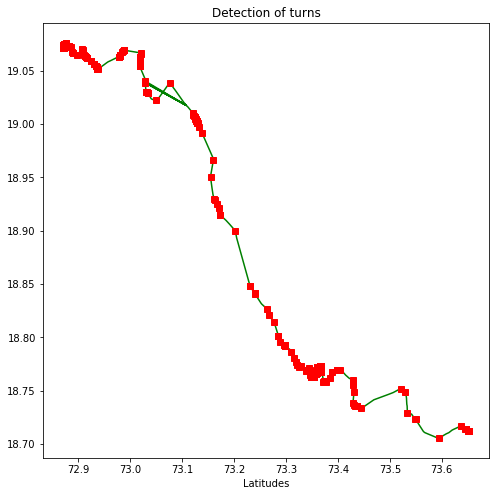

In [46]:
df_temp = df
df_turns = detect_turn(df_temp)
df_turns2 = detect_turn_rotated(df_temp)
df_merged = merge_turns(df_turns, df_turns2)
plot_turns(df_temp, df_merged, 8, 8)

In [47]:
df_merged.describe()

,start_index,end_index,start_lat,start_lon,end_lat,end_lon,speed_in,speed_out
count,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000
mean,67476.636856,67506.195122,18.970545,73.065533,18.970477,73.065745,16.389802,15.873969
std,12495.413164,12480.423616,0.138515,0.234175,0.138532,0.234233,23.512107,23.484649
min,51880.000000,51884.000000,18.705381,72.870610,18.705392,72.870608,0.000000,0.000000
25%,53910.000000,53919.250000,18.801181,72.872132,18.801178,72.872135,0.564860,0.539627
50%,66283.000000,66290.500000,19.062455,72.934679,19.062455,72.934679,3.791044,3.123630
75%,79371.750000,79375.000000,19.072012,73.285429,19.072012,73.285418,23.865335,21.719330
max,91497.000000,91500.000000,19.076542,73.652382,19.076535,73.652383,80.485142,80.485142


* Average speed at turns : 16.38

Lets find some turns where overspeeding is detected

Overspeed turns


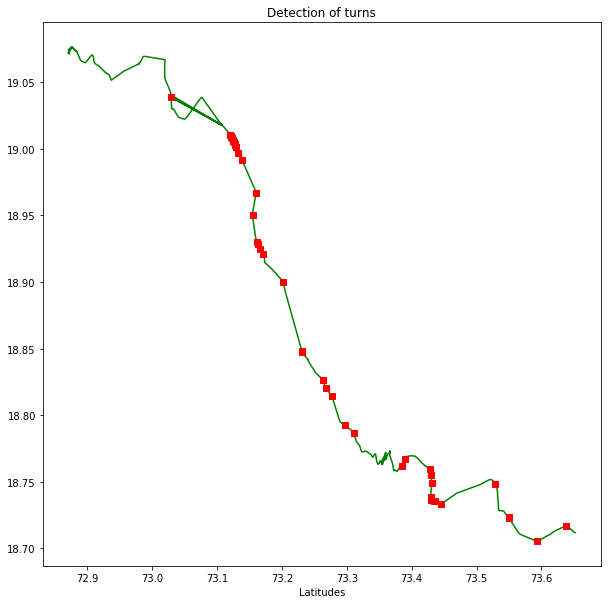

In [69]:
df_overspeed = df_merged[df_merged["speed_in"] >= 70]
print("Overspeed turns")
plot_turns(df_temp, df_overspeed, 10,10)
plot_turns_map(df_temp, df_overspeed, 10,10)

In [67]:
np.mean(df_merged["speed_in"])

16.389802246612433